In [3]:
using Knet
# using JLD2
using FileIO
using AutoGrad
using Images
using ImageMagick
using Random
using PyPlot
using Statistics
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth
import CUDA
import Knet.Ops20: conv4x
include("layers_BlockGAN.jl")
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32,N} where N

Start by loading list of images to be used

In [4]:
dataset = load("dataset//singleObjects64Array.jld", "data");

In [5]:
dataTrn = convert(array_type, dataset);

Create iterator for Clevr Dataset

In [6]:
struct ClevrData
    images
    batchsize::Int
    num_instances::Int
    function ClevrData(dataset; batchsize::Int=32) #shuffle::Bool=false)
        nFullBatches, rem = divrem(size(dataTrn)[end], batchsize)
        new(dataset[:,:,:,1:nFullBatches*batchsize], batchsize, nFullBatches*batchsize)
    end
end

In [7]:
function length(d::ClevrData)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

length (generic function with 222 methods)

In [8]:
function iterate(d::ClevrData, state=collect(1:d.num_instances))
    if length(state) > 0
        batch = d.images[:,:,:,state[1:(length(state) < d.batchsize ? end : d.batchsize)]]
        state  = state[d.batchsize+1:end]
        return (Param(batch)), state
    end
end

iterate (generic function with 438 methods)

In [9]:
function dAccuracy(G, D, z, real)
    fake = G(z)
    fakePred = sum((D(fake) .< 0.5) .== 1)
    truePred = sum((D(real) .> 0.5) .== 1)
    accuray = (fakePred + truePred)/(2*size(real)[end])
end

dAccuracy (generic function with 1 method)

In [10]:
function dAccFake(G, D, z)
    fake = G(z)
    fakePred = sum((D(fake) .< 0) .== 1)
    accuray = (fakePred )/(size(fake)[end])
end

dAccFake (generic function with 1 method)

In [11]:
function dAccReal(D, real_img)
    truePred = sum((D(real_img) .> 0) .== 1)
    accuray = truePred/(size(real_img)[end])
end

dAccReal (generic function with 1 method)

In [12]:
struct Backgroundx4
    learntConst
    upconv1
    upconv2
    batchSize
    imSize
    zMapper1
    zMapper2
    zMapper3
    repeatHelper
    function Backgroundx4(imSize::Int, batchSize::Int, zDim::Int)
        learntConst = Param(param(4,4,4,imSize*4,1, init=gaussian) .* 2)
        upconv1 = Deconv4(3,3,3,imSize*2,imSize*4,8,batchSize)
        upconv2 = Deconv4(3,3,3,imSize,imSize*2,16,batchSize)
        zMap1 = ZMapper(zDim, imSize*4) 
        zMap2 = ZMapper(zDim, imSize*2)
        zMap3 = ZMapper(zDim, imSize*1)
        tile = ones(4, 4, 4, imSize*4, batchSize)
        tile = convert(KnetArray{Float32}, tile)
        new(learntConst,upconv1,upconv2,batchSize,imSize,zMap1,zMap2,zMap3,tile)
    end
end

function (s::Backgroundx4)(z)
    w_tile = s.learntConst .* s.repeatHelper
    s0, b0 = s.zMapper1(z)
    h0 = AdaIN(w_tile, s0, b0)
    h0 = relu.(h0)
    
    h1 = s.upconv1(h0)
    s1, b1 = s.zMapper2(z)
    h1 = AdaIN(h1, s1, b1)
    h1 = relu.(h1)

    h2 = s.upconv2(h1)
    s2, b2 = s.zMapper3(z)
    h2 = AdaIN(h2, s2, b2)
    h2 = relu.(h2)
end

In [13]:
struct Foregroundx8
    learntConst
    upconv1
    upconv2
    batchSize
    imSize
    zMapper1
    zMapper2
    zMapper3
    repeatHelper
    function Foregroundx8(imSize::Int, batchSize::Int, zDim::Int)
        learntConst = Param(param(4,4,4,imSize*8,1, init=gaussian) .* 2)
        upconv1 = Deconv4(3,3,3,imSize*2,imSize*8,8,batchSize)
        upconv2 = Deconv4(3,3,3,imSize,imSize*2,16,batchSize)
        zMap1 = ZMapper(zDim, imSize*8) 
        zMap2 = ZMapper(zDim, imSize*2)
        zMap3 = ZMapper(zDim, imSize*1)
        tile = ones(4, 4, 4, imSize*8, batchSize)
        tile = convert(KnetArray{Float32}, tile)
        new(learntConst,upconv1,upconv2,batchSize,imSize,zMap1,zMap2,zMap3,tile)
    end
end

function (s::Foregroundx8)(z)
    w_tile = s.learntConst .* s.repeatHelper
    s0, b0 = s.zMapper1(z)
    h0 = AdaIN(w_tile, s0, b0)
    h0 = relu.(h0)
    
    h1 = s.upconv1(h0)
    s1, b1 = s.zMapper2(z)
    h1 = AdaIN(h1, s1, b1)
    h1 = relu.(h1)

    h2 = s.upconv2(h1)
    s2, b2 = s.zMapper3(z)
    h2 = AdaIN(h2, s2, b2)
    h2 = relu.(h2)
end

In [14]:
struct Discriminator
    layers
    Discriminator(layers...) = new(layers)
end
function (model::Discriminator)(x)
    for l in model.layers
        x = l(x)
    end
    x
end

In [52]:
struct Generator
    foreground
    background
    upconv1
    upconv2
    upconv3
    upconv4
    imSize
    function Generator(zDim, bs, imSize)
        fg = Foregroundx8(imSize, bs, zdim)
        bg = Backgroundx4(imSize, bs, zdim)
        upconv1 = Deconv(1,1,16*imSize,16*imSize)
        upconv2 = Deconv2(4,4,4*imSize,16*imSize,identity)
        upconv3 = Deconv2(4,4,imSize,4*imSize,identity)
        upconv4 = Deconv3(5,5,3,imSize,identity)
    new(fg,bg,upconv1,upconv2,upconv3,upconv4,imSize)
    end
end

function (model::Generator)(z)
    h2_fg = model.foreground(z)
#     h2_fg2 = model.foreground(Z_Sample(zdim,bs))
    h2_bg = model.background(z)
    h2_pool = max.(h2_bg,h2_fg2)
    h2_2d = reshape(h2_pool, (16,16,16*model.imSize,:))
    
    h3 = model.upconv1(h2_2d)
    
    h4 = model.upconv2(h3)
    h4  = relu.(h4)
    
    h5 = model.upconv3(h4)
    h5  = relu.(h5)
    
    h6 = model.upconv4(h5)

    output = tanh.(h6)
end

In [16]:
function sigmoid_cross_entropy_with_logits(logits, labels)
    zero = zeros(size(logits)); zero = convert(array_type, zero)
    one = ones(size(logits)); one = convert(array_type, one)
    max.(logits, zero) .- (logits .* labels) .+ log.(one .+ exp.(.- abs.(logits)))
end

sigmoid_cross_entropy_with_logits (generic function with 1 method)

In [17]:
function gLoss(G::Generator, D::Discriminator, z)
    logits = D(G(z))'
    labels = ones(size(logits))
    labels = convert(array_type, labels)
    return mean(sigmoid_cross_entropy_with_logits(logits, labels))
end

gLoss (generic function with 1 method)

In [18]:
function dLoss(D::Discriminator, realIms, fakeIms)
    labelsReal = ones(size(realIms)[end],1)
    labelsReal = convert(array_type, labelsReal)
    labelsFake = zeros(size(realIms)[end],1)
    labelsFake = convert(array_type, labelsFake)
    realLoss = mean(sigmoid_cross_entropy_with_logits(D(realIms)', labelsReal))
    fakeLoss = mean(sigmoid_cross_entropy_with_logits(D(fakeIms)', labelsFake))
    return realLoss+fakeLoss
end

dLoss (generic function with 1 method)

In [19]:
Random.seed!(1234)
loss_g = []
loss_d = []
acc_d_real = []
acc_d_fake = []
bs = 32
zdim = 128
imsize = 64
clevrDataset = ClevrData(dataTrn, batchsize=bs)
G = Generator(zdim, bs, imsize)
D = Discriminator(Conv(5,5,3,imsize), Conv_spectral(5,5,imsize,imsize*2), InstanceNorm(imsize*2), Conv_spectral(5,5,imsize*2,imsize*4), InstanceNorm(imsize*4), Conv_spectral(5,5,imsize*4,imsize*8), InstanceNorm(imsize*8), Dense(4*4*imsize*8,1,identity))

Discriminator((Conv(P(KnetArray{Float32,4}(5,5,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), leakyRelu), Conv_spectral(P(KnetArray{Float32,4}(5,5,64,128)), P(KnetArray{Float32,4}(1,1,128,1)), leakyRelu), InstanceNorm(P(KnetArray{Float32,4}(1,1,128,1)), P(KnetArray{Float32,4}(1,1,128,1))), Conv_spectral(P(KnetArray{Float32,4}(5,5,128,256)), P(KnetArray{Float32,4}(1,1,256,1)), leakyRelu), InstanceNorm(P(KnetArray{Float32,4}(1,1,256,1)), P(KnetArray{Float32,4}(1,1,256,1))), Conv_spectral(P(KnetArray{Float32,4}(5,5,256,512)), P(KnetArray{Float32,4}(1,1,512,1)), leakyRelu), InstanceNorm(P(KnetArray{Float32,4}(1,1,512,1)), P(KnetArray{Float32,4}(1,1,512,1))), Dense(P(KnetArray{Float32,2}(1,8192)), P(KnetArray{Float32,1}(1)), identity)))

In [20]:
# JLD2.@save "BlockGAN_models//8Epochs.jld2" G D
# JLD2.@load "BlockGAN_models//8Epochs.jld2" G D

In [32]:
# FileIO.save("BlockGAN_models//3Epochs.jld2", "G", G, "D", D)

In [50]:
G, D = load("BlockGAN_models//20Epochs.jld2", "G", "D")

(Generator(Foregroundx8(P(KnetArray{Float32,5}(4,4,4,512,1)), Deconv4(P(KnetArray{Float32,5}(3,3,3,128,512)), P(KnetArray{Float32,5}(1,1,1,128,1)), Knet.Ops20.relu, K32(8,8,8,128,32)[0.0⋯], 1, 2), Deconv4(P(KnetArray{Float32,5}(3,3,3,64,128)), P(KnetArray{Float32,5}(1,1,1,64,1)), Knet.Ops20.relu, K32(16,16,16,64,32)[0.0004137987⋯], 1, 2), 32, 64, ZMapper(P(KnetArray{Float32,2}(1024,128)), P(KnetArray{Float32,1}(1024)), 512, Knet.Ops20.relu), ZMapper(P(KnetArray{Float32,2}(256,128)), P(KnetArray{Float32,1}(256)), 128, Knet.Ops20.relu), ZMapper(P(KnetArray{Float32,2}(128,128)), P(KnetArray{Float32,1}(128)), 64, Knet.Ops20.relu), K32(4,4,4,512,32)[1.0⋯]), Backgroundx4(P(KnetArray{Float32,5}(4,4,4,256,1)), Deconv4(P(KnetArray{Float32,5}(3,3,3,128,256)), P(KnetArray{Float32,5}(1,1,1,128,1)), Knet.Ops20.relu, K32(8,8,8,128,32)[0.113497026⋯], 1, 2), Deconv4(P(KnetArray{Float32,5}(3,3,3,64,128)), P(KnetArray{Float32,5}(1,1,1,64,1)), Knet.Ops20.relu, K32(16,16,16,64,32)[0.0⋯], 1, 2), 32, 64, ZM

In [21]:
# for par in params(D)
#     println(mean(par))
#     println(std(par))
#     println()
# end

In [23]:
function main()
    i = 0
    for real_image in ncycle(clevrDataset, 20)
        bs = size(real_image)[end]
        z = Z_Sample(zdim,bs)
        if i % 25 == 0
            push!(loss_g, gLoss(G, D, z))
            push!(loss_d, dLoss(D, real_image, G(z)))
            print("$(i): GenLoss: ");print(loss_g[end])
            print("    DisLoss: ");print(loss_d[end])
            push!(acc_d_real, dAccReal(D, real_image))
            push!(acc_d_fake, dAccFake(G,D,z))
            print("    AccReal: ");print(acc_d_real[end])
            print("    AccFake: ");println(acc_d_fake[end])
        end
#         if i % 2 == 0
        adam!(dLoss, [(D, real_image, G(z))], gclip = 5, lr = 0.0001, beta1=0.5)#, params=params(D))
#         end
        adam!(gLoss, [(G, D, z)], params=params(G), gclip = 5, lr = 0.0001,beta1=0.5)
        adam!(gLoss, [(G, D, z)], params=params(G), gclip = 5, lr = 0.0001,beta1=0.5)
        i += 1
    end
end

main (generic function with 1 method)

In [33]:
main()

0: GenLoss: 1.9177263    DisLoss: 1.6849902    AccReal: 0.28125    AccFake: 1.0
25: GenLoss: 2.0332046    DisLoss: 0.58819455    AccReal: 0.6875    AccFake: 1.0
50: GenLoss: 2.9257727    DisLoss: 1.1674738    AccReal: 0.625    AccFake: 1.0
75: GenLoss: 3.7259328    DisLoss: 1.0713197    AccReal: 0.5    AccFake: 1.0
100: GenLoss: 2.0120852    DisLoss: 0.7050677    AccReal: 0.71875    AccFake: 1.0
125: GenLoss: 2.198475    DisLoss: 0.64554954    AccReal: 0.65625    AccFake: 1.0
150: GenLoss: 1.0750251    DisLoss: 1.2713637    AccReal: 0.625    AccFake: 1.0
175: GenLoss: 1.1919236    DisLoss: 0.66225517    AccReal: 0.875    AccFake: 0.96875
200: GenLoss: 1.608203    DisLoss: 0.550875    AccReal: 0.8125    AccFake: 1.0
225: GenLoss: 1.3556012    DisLoss: 0.5459515    AccReal: 0.90625    AccFake: 1.0
250: GenLoss: 2.3277652    DisLoss: 0.83485097    AccReal: 0.5    AccFake: 1.0
275: GenLoss: 1.3621631    DisLoss: 1.036632    AccReal: 0.5    AccFake: 1.0
300: GenLoss: 1.3797352    DisLoss: 0

LoadError: InterruptException:

In [59]:
lossPlot = plot([loss_g, loss_d],labels=["Gen" ,"Dis"],xlabel="Iters",ylabel="Loss");

LoadError: MethodError: no method matching *(::Type{Array{Float32,N} where N}, ::Array{Any,1})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::PyCall.PyObject, ::Any) at /kuacc/users/aanees20/.julia/packages/PyCall/BcTLp/src/pyoperators.jl:13
  *(!Matched::LinearAlgebra.Transpose{var"#s828",var"#s827"} where var"#s827"<:StridedArray{T, 2} where var"#s828", ::StridedArray{S, 1}) where {T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64}, S} at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/matmul.jl:84
  ...

In [ ]:
lossPlot = plot([acc_d_real, acc_d_fake],labels=["Real" ,"Fake"],xlabel="Iters",ylabel="Loss")

In [27]:
function myGrid(images, rows, cols)
    images = convert(Array{Float32}, value(images))
    nIms = size(images)[end]
    k = 1
    big_img = zeros(64*rows, 64*cols, 3)
    big_img = convert(Array{Float32}, value(big_img))
    for i in 0:rows-1
        for j in 0:cols-1
            big_img[(64*i)+1:(64*(i+1)), (64*j)+1:(64*(j+1)),:] .= img[:,:,:,k]
            k+=1
            k > nIms && break
        end
    end
    big_img = big_img .- minimum(big_img)
    big_img= big_img ./ maximum(big_img)
end

myGrid (generic function with 1 method)

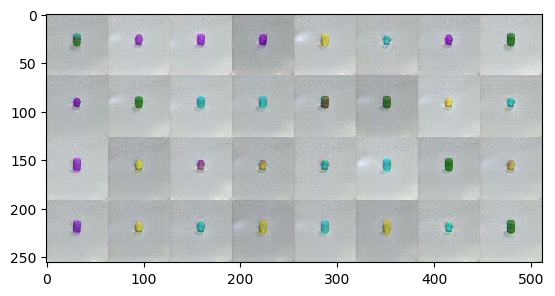

PyObject <matplotlib.image.AxesImage object at 0x2b61cd742400>

In [49]:
#
z = Z_Sample(zdim,bs)
img = G(z)
big_img = myGrid(img, 4, 8)
imshow(big_img)

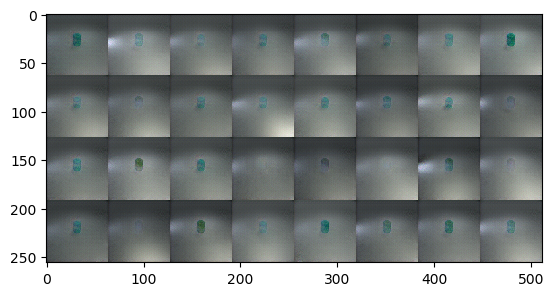

PyObject <matplotlib.image.AxesImage object at 0x2b61cd490898>

In [47]:
#
z = Z_Sample(zdim,bs)
img = G(z)
big_img = myGrid(img, 4, 8)
imshow(big_img)

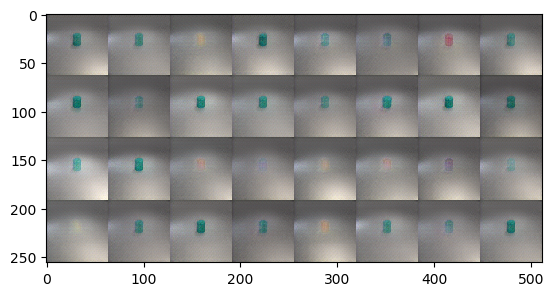

PyObject <matplotlib.image.AxesImage object at 0x2b61cd990eb8>

In [54]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = myGrid(img, 4, 8)
imshow(big_img)

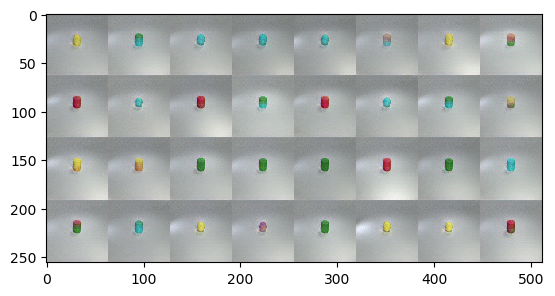

PyObject <matplotlib.image.AxesImage object at 0x2b61cd83b978>

In [43]:
# 2 objects
z = Z_Sample(zdim,bs)
img = G(z)
big_img = myGrid(img, 4, 8)
imshow(big_img)

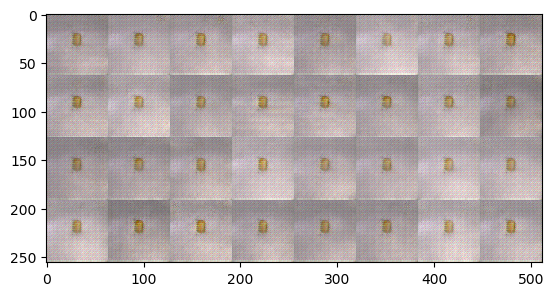

PyObject <matplotlib.image.AxesImage object at 0x2b95e0a6cac8>

In [233]:
# 1 epoch
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

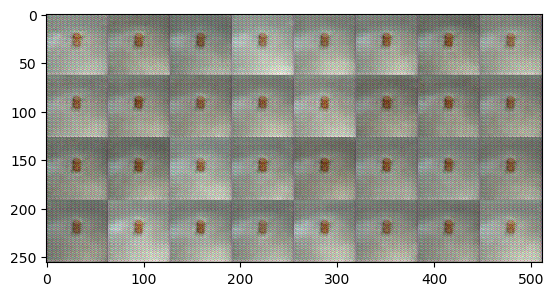

PyObject <matplotlib.image.AxesImage object at 0x2b61cd58f390>

In [28]:
# 2 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = myGrid(img, 4, 8)
imshow(big_img)

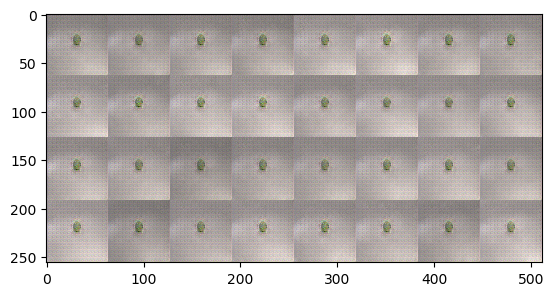

PyObject <matplotlib.image.AxesImage object at 0x2b61cd6d8748>

In [35]:
# 3 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = myGrid(img, 4, 8)
imshow(big_img)

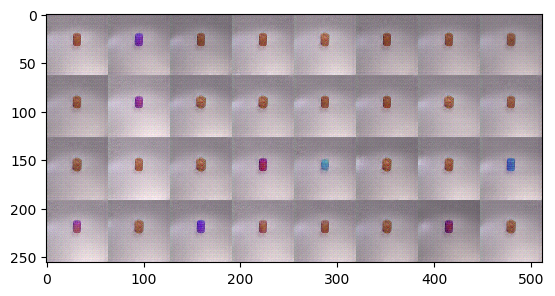

PyObject <matplotlib.image.AxesImage object at 0x2b95e2811978>

In [209]:
# 4 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

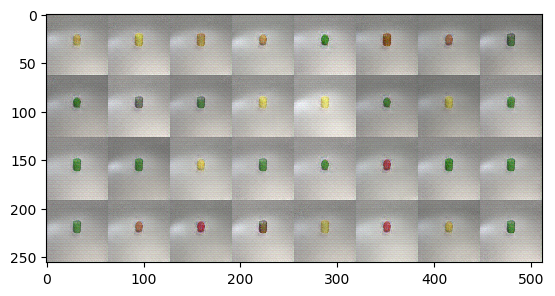

PyObject <matplotlib.image.AxesImage object at 0x2b95e027a358>

In [211]:
# 6 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

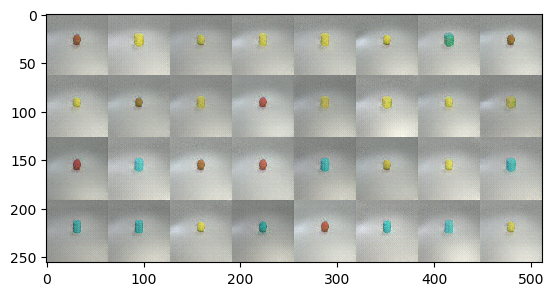

PyObject <matplotlib.image.AxesImage object at 0x2b95e287e940>

In [213]:
# 8 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

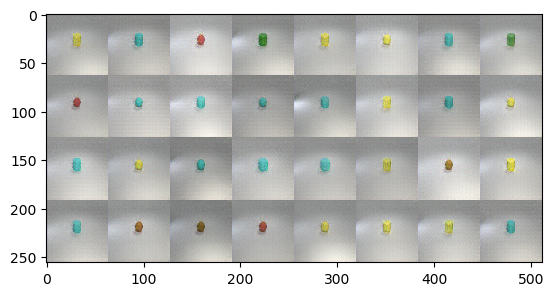

PyObject <matplotlib.image.AxesImage object at 0x2b95e07e54e0>

In [215]:
# 10 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

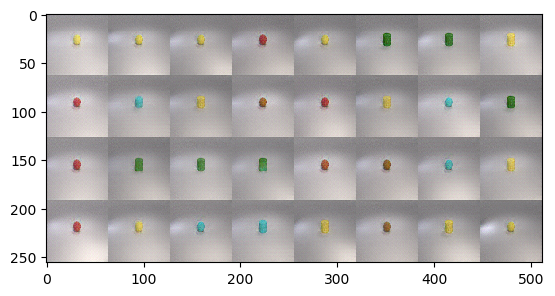

PyObject <matplotlib.image.AxesImage object at 0x2b95e084b080>

In [217]:
# 12 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

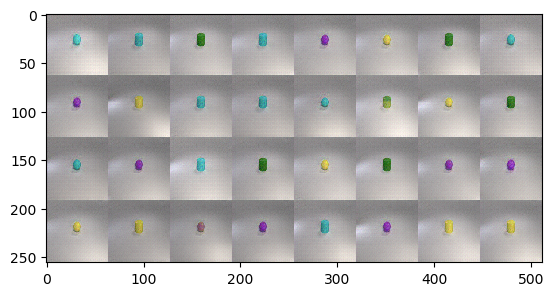

PyObject <matplotlib.image.AxesImage object at 0x2b95e09b7860>

In [225]:
# 14 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

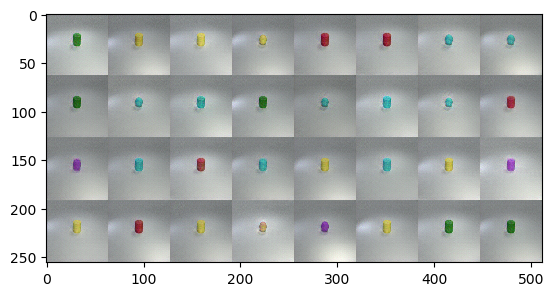

PyObject <matplotlib.image.AxesImage object at 0x2b95e08f5160>

In [221]:
# 16 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

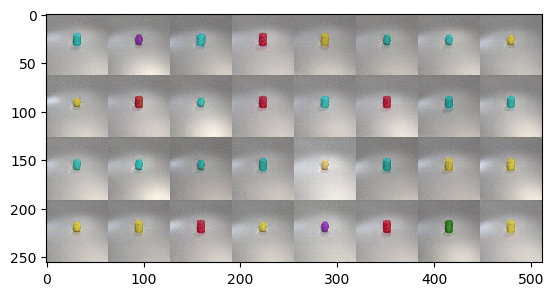

PyObject <matplotlib.image.AxesImage object at 0x2b95e0952cc0>

In [223]:
# 20 epochs
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

In [207]:
# realIms = convert(Array{Float32}, realIms)
# imshow(realIms[:,:,:,6])

In [206]:
# realIms = first(clevrDataset)[:,:,:,:]
# big_img = grid(realIms, 4, 8)
# imshow(big_img)

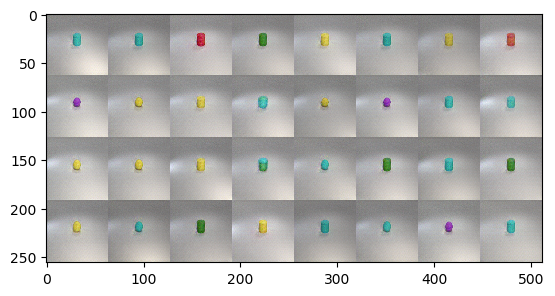

PyObject <matplotlib.image.AxesImage object at 0x2b95e0431630>

In [171]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

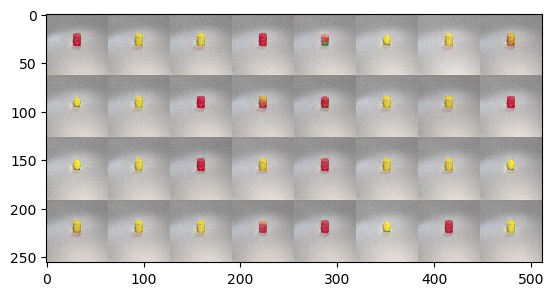

PyObject <matplotlib.image.AxesImage object at 0x2b95e00d05f8>

In [114]:
z = Z_Sample(zdim,1)
img = G(z)
big_img = grid(img, 4, 8)

imshow(big_img)

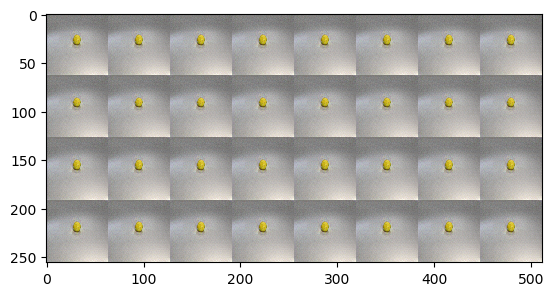

PyObject <matplotlib.image.AxesImage object at 0x2b95e8337e10>

In [83]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)

imshow(big_img)

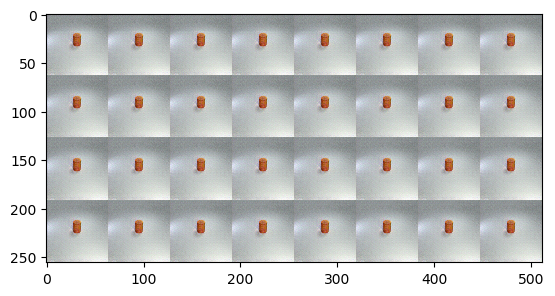

PyObject <matplotlib.image.AxesImage object at 0x2b95e811d2b0>

In [75]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)

imshow(big_img)

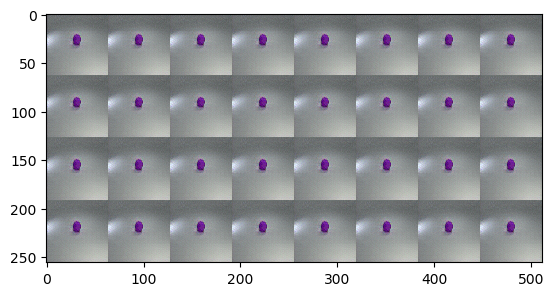

PyObject <matplotlib.image.AxesImage object at 0x2b95e80be748>

In [74]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)

imshow(big_img)

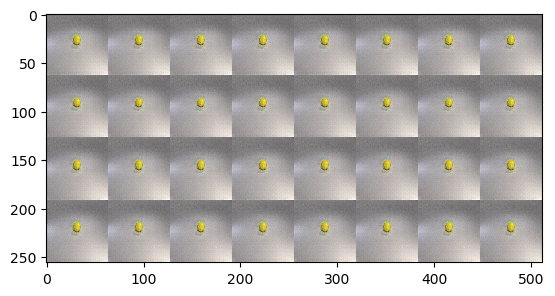

PyObject <matplotlib.image.AxesImage object at 0x2b95e806bcc0>

In [67]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)

imshow(big_img)

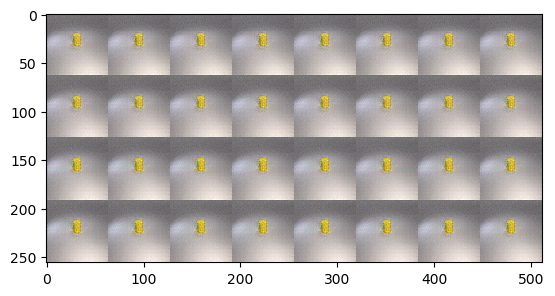

PyObject <matplotlib.image.AxesImage object at 0x2b95dded5be0>

In [61]:
z = Z_Sample(zdim,bs)
img = G(z)
big_img = grid(img, 4, 8)
imshow(big_img)

In [ ]:
z = Z_Sample(zdim,bs)
img = G(z)
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)

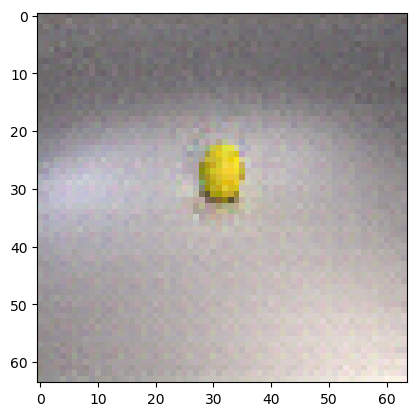

PyObject <matplotlib.image.AxesImage object at 0x2b95dd7e8588>

In [37]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

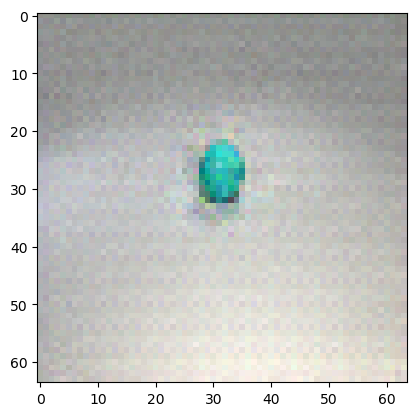

PyObject <matplotlib.image.AxesImage object at 0x2b95dd790be0>

In [32]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

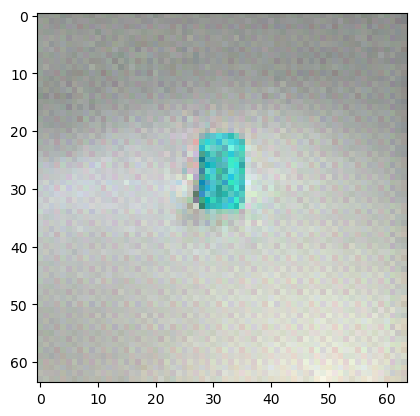

PyObject <matplotlib.image.AxesImage object at 0x2b8a662966a0>

In [161]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

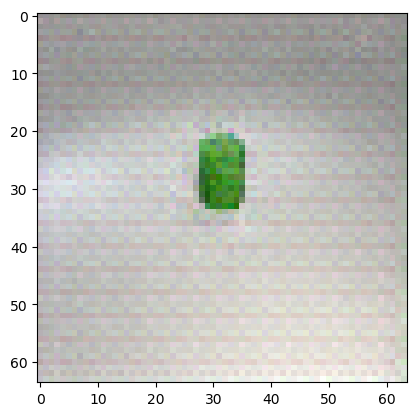

PyObject <matplotlib.image.AxesImage object at 0x2b8a05e735f8>

In [148]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

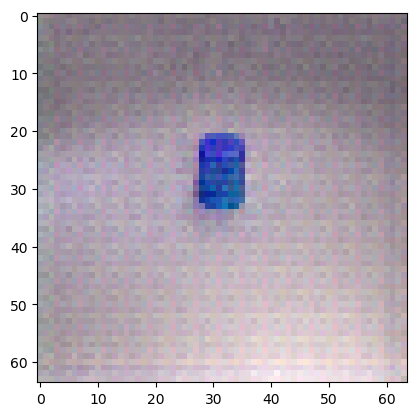

PyObject <matplotlib.image.AxesImage object at 0x2b8a05b93ac8>

In [133]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

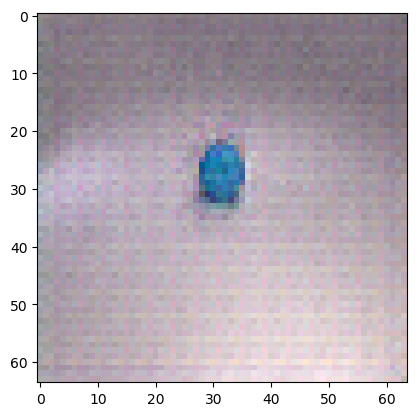

PyObject <matplotlib.image.AxesImage object at 0x2b8a05c4a780>

In [143]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

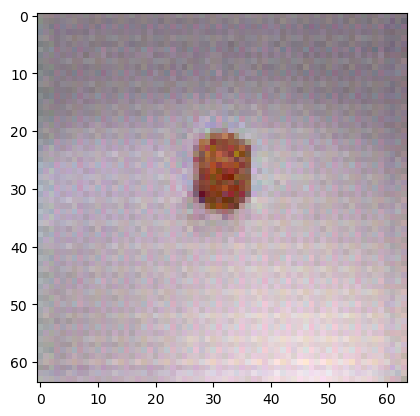

PyObject <matplotlib.image.AxesImage object at 0x2b89bbf6a048>

In [128]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

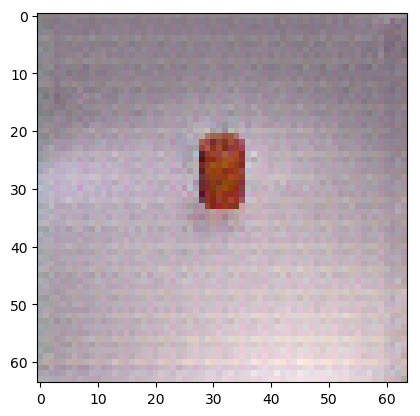

PyObject <matplotlib.image.AxesImage object at 0x2b89bbfc7588>

In [129]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

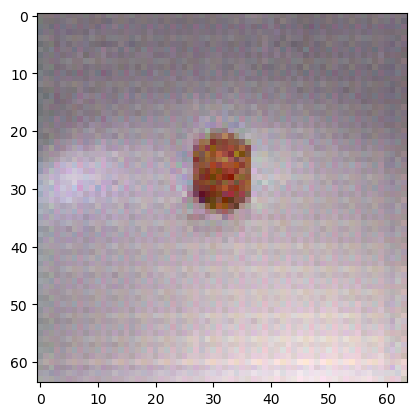

PyObject <matplotlib.image.AxesImage object at 0x2b8a05a67ac8>

In [130]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

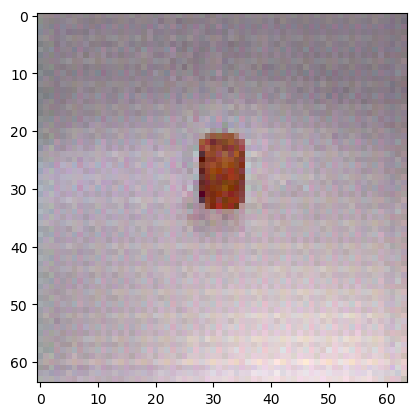

PyObject <matplotlib.image.AxesImage object at 0x2b8a05ac8a90>

In [131]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

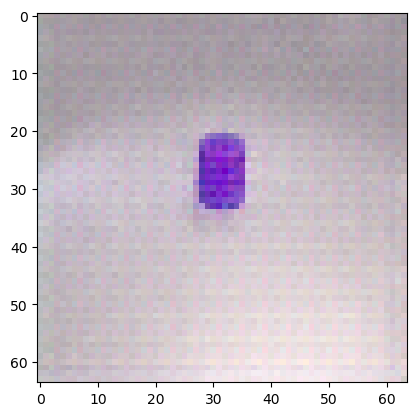

PyObject <matplotlib.image.AxesImage object at 0x2b8a05bfd048>

In [134]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

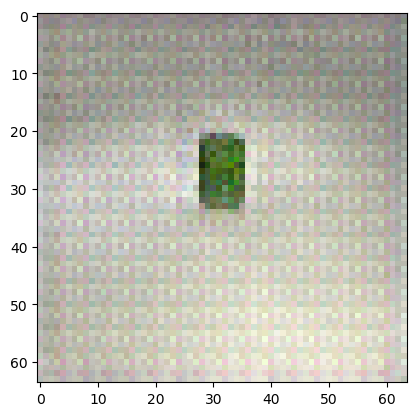

PyObject <matplotlib.image.AxesImage object at 0x2b89bbb9bc88>

In [117]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

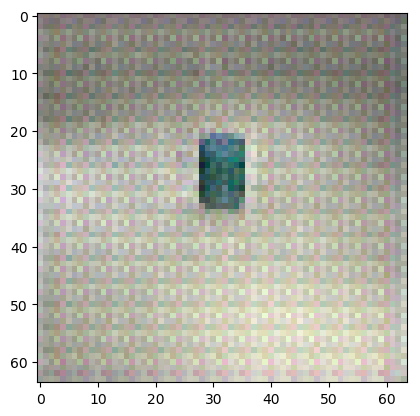

PyObject <matplotlib.image.AxesImage object at 0x2b89bbc06208>

In [118]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

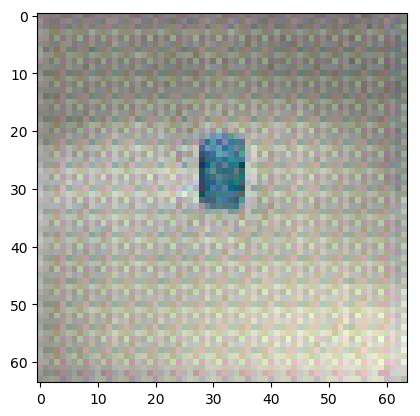

PyObject <matplotlib.image.AxesImage object at 0x2b89bbc63748>

In [119]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

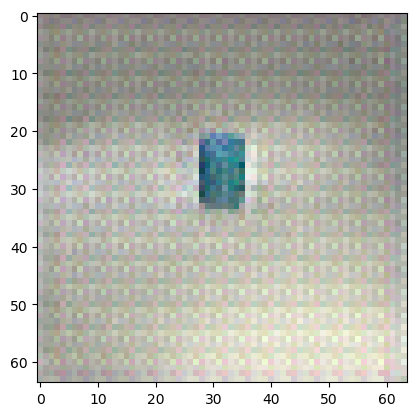

PyObject <matplotlib.image.AxesImage object at 0x2b89bbccd240>

In [120]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

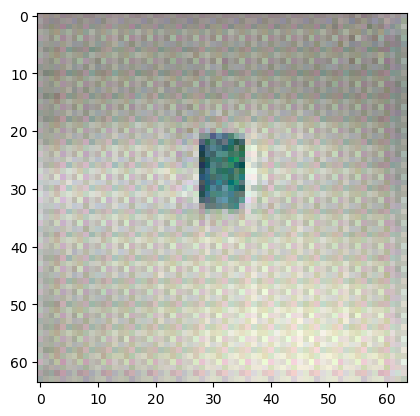

PyObject <matplotlib.image.AxesImage object at 0x2b89bbd2f780>

In [121]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

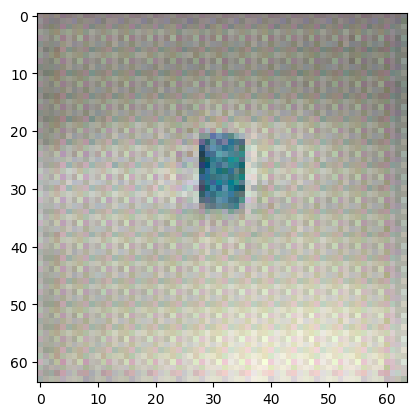

PyObject <matplotlib.image.AxesImage object at 0x2b89bbd90cc0>

In [122]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

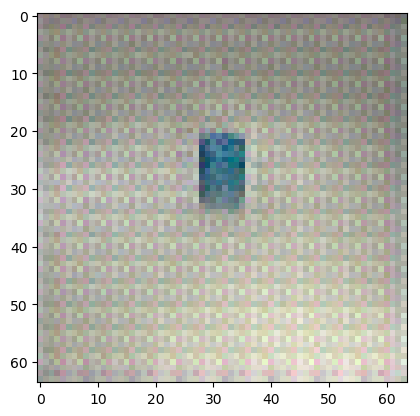

PyObject <matplotlib.image.AxesImage object at 0x2b89bbddedd8>

In [123]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

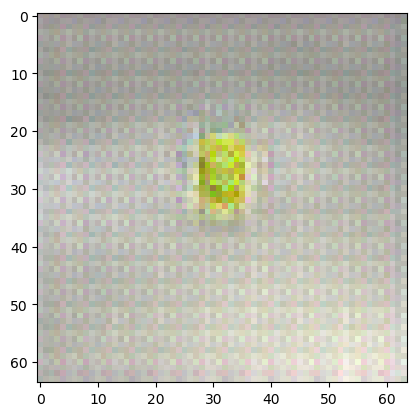

PyObject <matplotlib.image.AxesImage object at 0x2b89bbe40358>

In [124]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

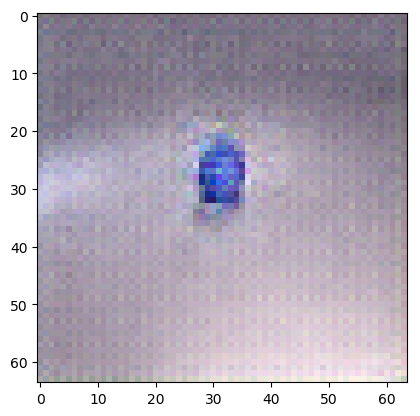

PyObject <matplotlib.image.AxesImage object at 0x2af13c441400>

In [89]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

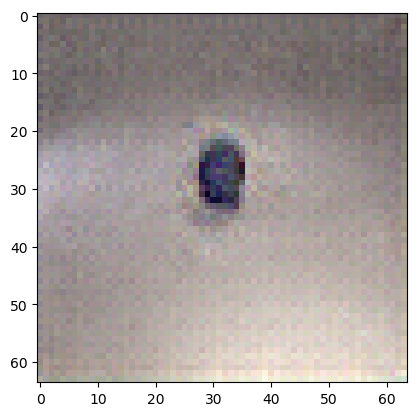

PyObject <matplotlib.image.AxesImage object at 0x2af13c4a1940>

In [90]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

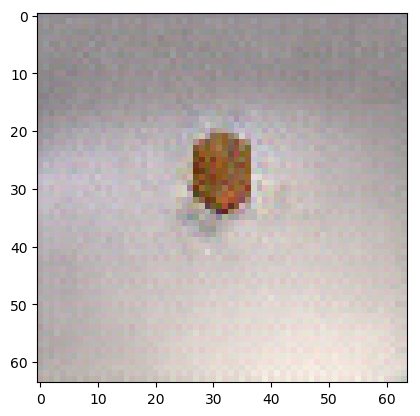

PyObject <matplotlib.image.AxesImage object at 0x2af13c501e80>

In [91]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

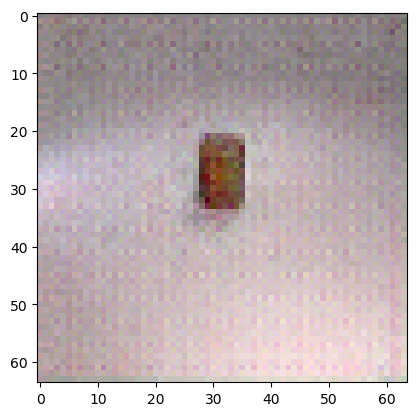

PyObject <matplotlib.image.AxesImage object at 0x2af13c56b400>

In [92]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

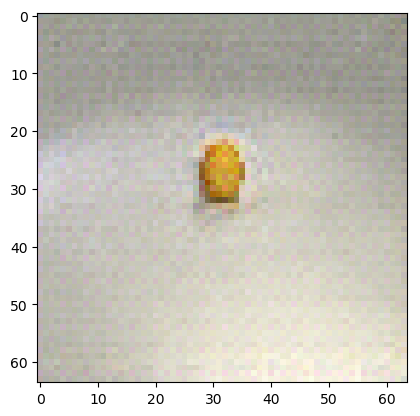

PyObject <matplotlib.image.AxesImage object at 0x2af13c5cc3c8>

In [93]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

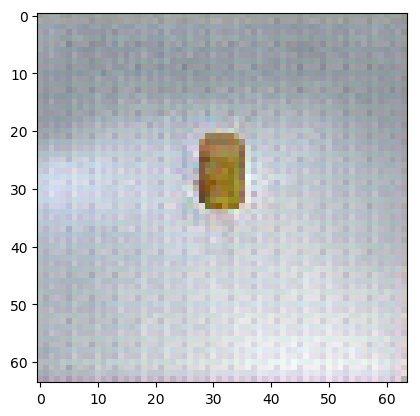

PyObject <matplotlib.image.AxesImage object at 0x2af13596bba8>

In [49]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

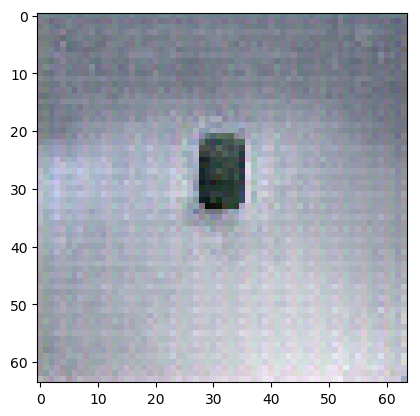

PyObject <matplotlib.image.AxesImage object at 0x2af1359c7dd8>

In [55]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

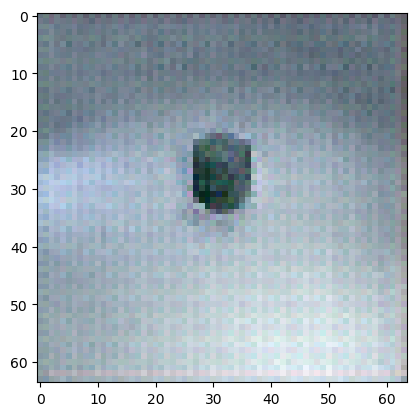

PyObject <matplotlib.image.AxesImage object at 0x2af135a33358>

In [56]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

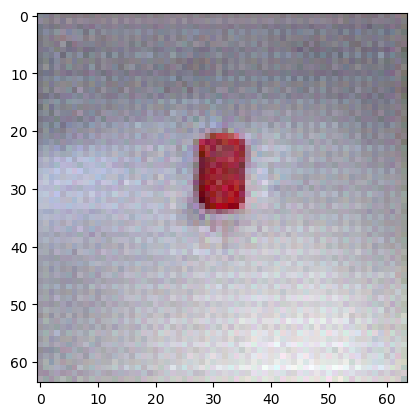

PyObject <matplotlib.image.AxesImage object at 0x2af135a92898>

In [57]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

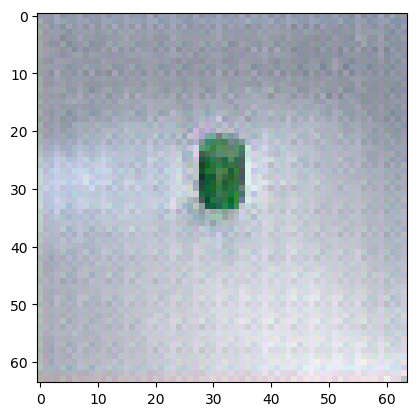

PyObject <matplotlib.image.AxesImage object at 0x2af135af3dd8>

In [58]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

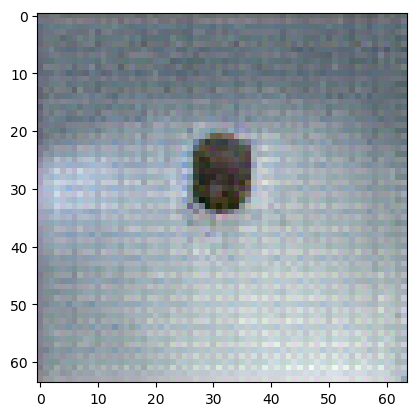

PyObject <matplotlib.image.AxesImage object at 0x2af135b60358>

In [59]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

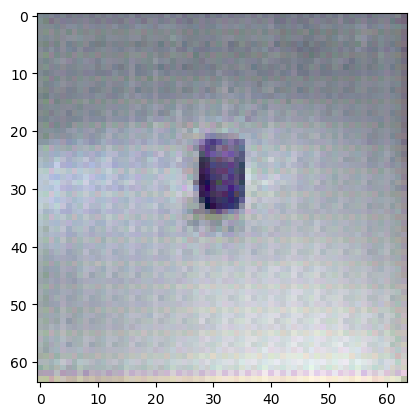

PyObject <matplotlib.image.AxesImage object at 0x2af135bbe898>

In [60]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

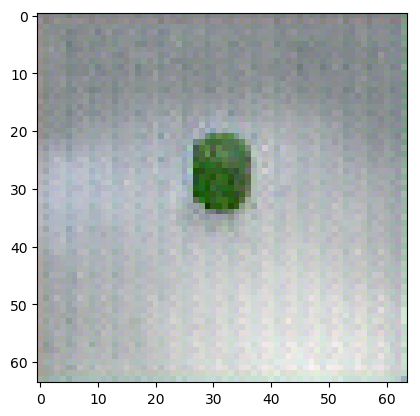

PyObject <matplotlib.image.AxesImage object at 0x2af135c21dd8>

In [61]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

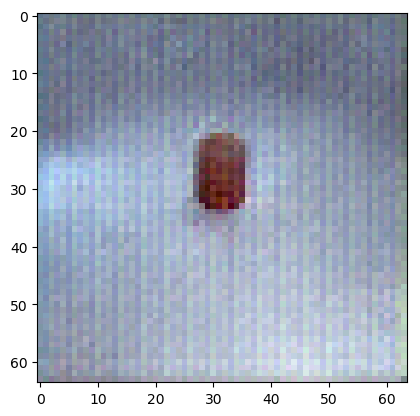

PyObject <matplotlib.image.AxesImage object at 0x2af135c81da0>

In [62]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

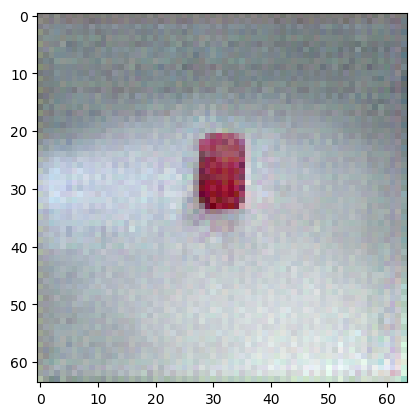

PyObject <matplotlib.image.AxesImage object at 0x2af135ced898>

In [63]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

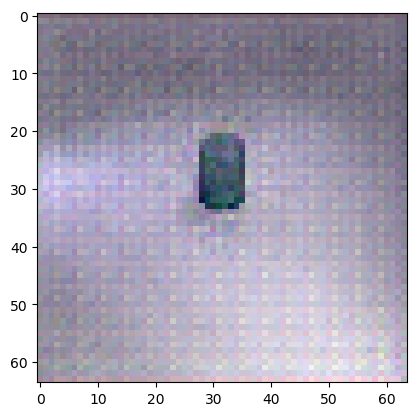

PyObject <matplotlib.image.AxesImage object at 0x2af135d4ddd8>

In [64]:
z = Z_Sample(zdim,bs)
img = G(z)[:,:,:,1]
img = convert(Array{Float32}, value(img));
img = img .- minimum(img)
img = img ./ maximum(img)
imshow(img)

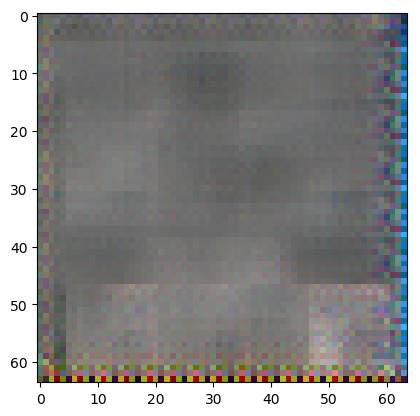

Self noise Generate

PyObject <matplotlib.image.AxesImage object at 0x2acffcef49b0>

In [99]:
img = G(1)[:,:,:,1]
img = convert(Array{Float32}, value(img))
imshow(img)

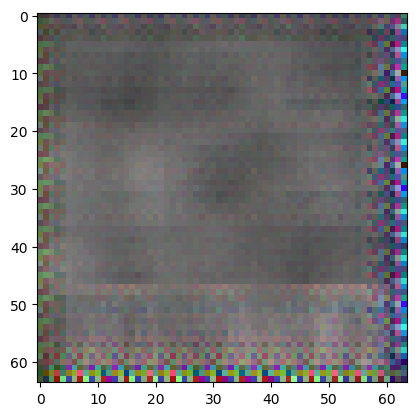

Self noise Generate

PyObject <matplotlib.image.AxesImage object at 0x2acffce965f8>

In [92]:
img = G(1)[:,:,:,1]
img = convert(Array{Float32}, value(img))
imshow(img)

In [75]:
# img = img ./ maximum(img, dims = 3);
# imshow(img);
# # img

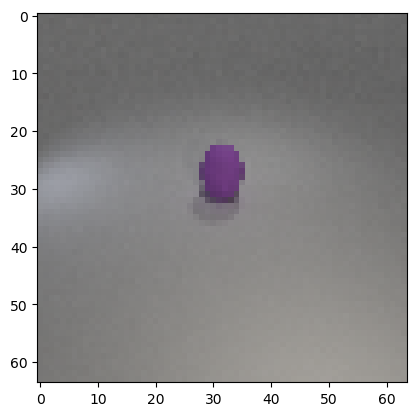

PyObject <matplotlib.image.AxesImage object at 0x2b49d2f05f28>

In [43]:
clevrDataset1 = ClevrData(singleObj)
img1= first(take(clevrDataset1, 1))[:,:,:,1]
img1 = convert(Array{Float32}, value(img1))
imshow(img1)

In [44]:
G(1)

LoadError: CUDNNError: CUDNN_STATUS_INTERNAL_ERROR (code 4)

In [45]:
D(first(take(clevrDataset1, 1)))

LoadError: CUDNNError: CUDNN_STATUS_INTERNAL_ERROR (code 4)

In [46]:
# a = param(16,16,1024,10)
# Deconv(1,1,64,16*64)(a)

In [47]:
# a = Deconv2(3,3,3,128,512)
# a(param(4,4,4,512,1))
# b = Deconv2(4,4,4,64,128)
# b(a(param(4,4,4,512,1)))

In [48]:
# background = ObjectGenerator()
# foreground = ObjectGenerator()
# composedScene = max.(background, foreground)
# concat = reshape(composedScene, (16,16,16*64,1))
# c1 = Conv(1,1,1024,64)
# projected = c1(concat)

In [45]:
# # bs = 32
# # a = Scene(256,512,bs)
# # # bt = Z4(4,4,4,256,32)
# # # a = Deconv4(3,3,3,128,f,8,32)
# bg = Z4(4,4,4,256,bs)
# fg = Z4(4,4,4,512,bs)
# z = (bg, fg)

# # a(bg, fg)
# # # ft = Z4(4,4,4,512,32)

# # w = param(3,3,3,128,512)
# # b=param0(1,1,1,128,1)
# # o=KnetArray{Float32}(undef,8, 8, 8, 128, 1)

# # out = conv4x(w,o,ft, padding =1, stride = 2)


(K32(4,4,4,256,32)[0.93970644⋯], K32(4,4,4,512,32)[0.9021163⋯])

In [80]:
# struct Generator2
#     layers
#     Generator2(layers...) = new(layers)
# end
# # (model::Generator2)(x) = (for l in model.layers; x = l(x); end; x)

# function (model::Generator2)(z)
#     layers = model.layers
# #     length(z) == 2 ? x = layers[1](z[1],z[2]) : x = layers[1]()
#     x = layers[1](z)
#     for i in collect(2:length(layers))
#        x = layers[i](x)
#     end
#     x
# end

In [49]:
# FG = Chain(Deconv2(4,4,4,128,512), Deconv2(4,4,4,64,128))
# BG = Chain(Deconv2(4,4,4,128,256), Deconv2(4,4,4,64,128))
# f  = FG(Z3(4,4,4,512,1))
# b  = BG(Z3(4,4,4,256,1))
# SceneComposer(f,b)

In [53]:
# z = Z3(4,4,4,512,1)

In [54]:
# Random.seed!(123)
# a = Deconv4(3,3,3,128,512,8)
# a(z)

In [52]:
# Random.seed!(123)
# a = Deconv4(3,3,3,128,512,7)
# a(z);

In [53]:
# Random.seed!(1234)
# loss_g = []
# loss_d = []
# moments1 = bnmoments()
# params1 = param(bnparams(3))
# G = Generator2(Dense(128, 12288, sigm), Reshape1())
# D = Discriminator2(Conv(5,5,3,64,leakyRelu), Dense(65536, 1, sigm))

In [54]:
# a = Conv(5,5,3,64)
# b = Conv(5,5,64,128)
# c = Conv(5,5,128,256)
# d = Conv(5,5,256,512)
# e = Dense(4*4*512,1,sigm)
# e(d(c(b(a(param(64,64,3,1))))))

In [55]:
# a = Conv(1,1,1024,64)
# a(param(randn(16,16,1024,1)))

In [548]:
# e = a(Z2(16,16,16*64,1))
# f = b(e)
# g = b(f)
# h = c(g)

In [33]:
# a = Deconv2(4,4,64,16*64)

# a(param(16,16,16*64,1))

LoadError: CUDNNError: CUDNN_STATUS_INTERNAL_ERROR (code 4)

In [550]:
# x = randn(16, 16, 16*64, 1)
# w = randn(4, 4, 64, 16*64)
# y = deconv4(w, x, stride = 2, padding = 1)

In [551]:
# a = 3
# a(param(randn(16,16,1024,1)))

In [552]:
# a = Deconv(1,1,64,16*64)
# a(param(16,16,16*64,1))
# b = Deconv2(4,4,64,64)
# b(b(param(16,16,64,1)))
# c = Deconv3(5,5,3,64)
# c(param(64,64,64,1))

In [553]:
# function make_minibatch(names, batchSize = 128)
#     rem = mod(length(names), batchSize)
#     names = reshape(names[1:end-rem], :, batchSize)
# end

# batches = make_minibatch(singleObj, 64)
# batch = load_batch(batches, 1)